In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100
})



from Finite_volume_method_1D import *

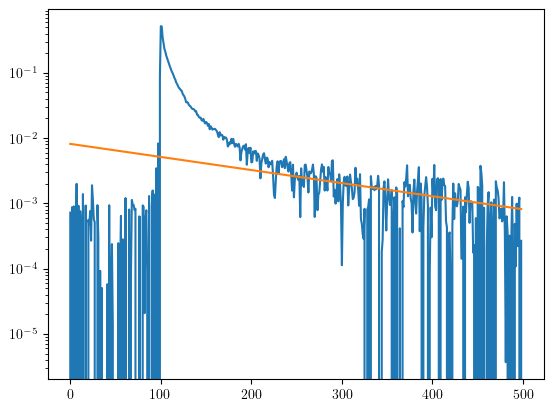

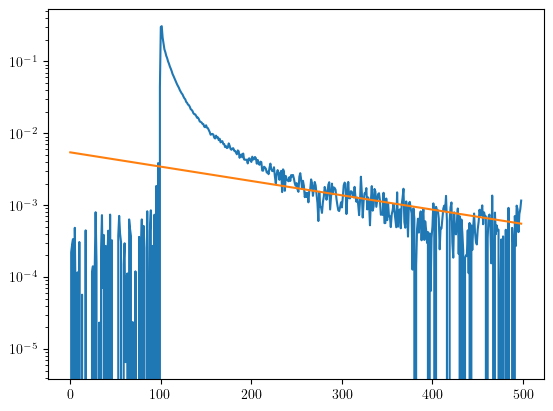

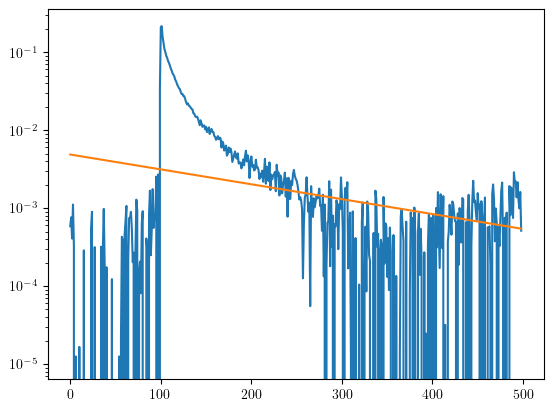

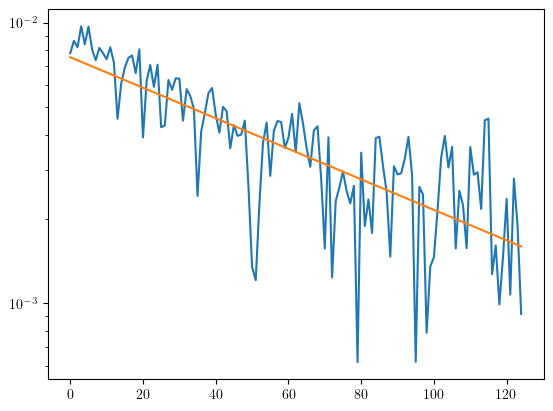

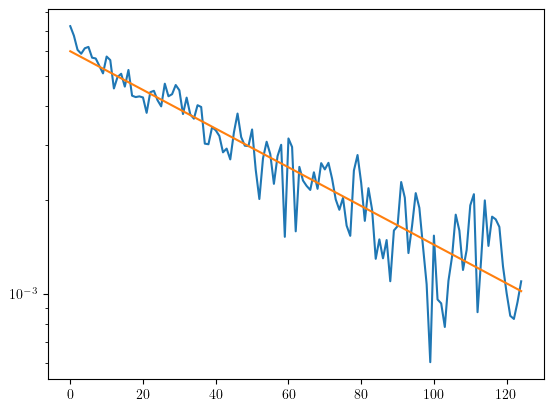

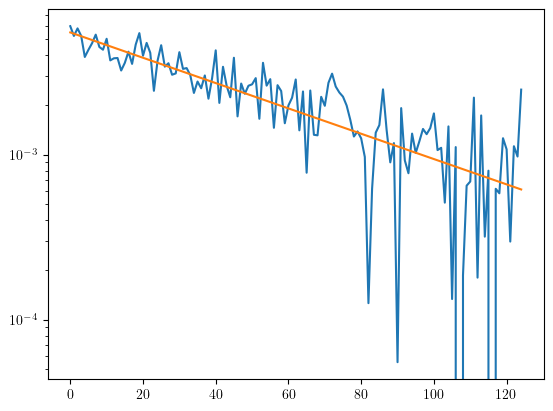

In [3]:
chippath = '../../DataKian/bTa_LT354chip3/'
filename = 'KID14_92dBm__TmK20_avgpulse_ampphase.csv' # try 92dBm and 96 of this KID, both have good pulses at all 3 wavelengths
length = 48
simtime = 100
dtinit=0.001
dxfrac=1/5

lambdasinnm = [402,673,986]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=True) # just to plot full pulses
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=175,end=300,showplots=True) # actually calculate tauqp*

In [4]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

79.76948403356127 6.282616711408312
0.012536122204065803
69.86672847214375 2.621764814932133
0.014312964437696628
56.59994383967418 4.491649792276684
0.01766786205358462


In [5]:
def prep_data(offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(offset,offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,eta,sigma,tau,Q0):
    print('eta (-):\t',eta)
    print('sigma (um):\t',sigma)
    print('tau (us):\t',tau)
    print('Q0 (um-1):\t',Q0)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return SIM

def plotsim(eta,sigma,tau,Q0):
    datalist = Parallel(n_jobs=4)(delayed(par_func_plot)(KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [22]:
xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.5,5,0.2,0.5],bounds=[[0.01,0.2,0.01,0.1],[1,length/6,10,np.inf]]) #with tau
print('\nDone!')

eta (-):	 0.5
sigma (um):	 5.0
tau (us):	 0.2
Q0 (um-1):	 0.5
Iteration: 1312	Simtime (us): 100.51418976907618
Iteration: 1550	Simtime (us): 100.27546038644698
Iteration: 1746	Simtime (us): 100.25291994394335
eta (-):	 0.5000000149011612
sigma (um):	 5.0
tau (us):	 0.2
Q0 (um-1):	 0.5
Iteration: 1312	Simtime (us): 100.51419668774493
Iteration: 1550	Simtime (us): 100.27548751107054
Iteration: 1746	Simtime (us): 100.25297757985035
eta (-):	 0.5
sigma (um):	 5.000000074505806
tau (us):	 0.2
Q0 (um-1):	 0.5
Iteration: 1312	Simtime (us): 100.51418850342918
Iteration: 1550	Simtime (us): 100.27545052583311
Iteration: 1746	Simtime (us): 100.25289765427656
eta (-):	 0.5
sigma (um):	 5.0
tau (us):	 0.2000000149011612
Q0 (um-1):	 0.5
Iteration: 1131	Simtime (us): 15.933526374293248
Iteration: 1550	Simtime (us): 100.27531035977749
Iteration: 1746	Simtime (us): 100.25255397705827
eta (-):	 0.5
sigma (um):	 5.0
tau (us):	 0.2
Q0 (um-1):	 0.5000000149011612
Iteration: 1062	Simtime (us): 17.4320118846

In [6]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['eta','sigma','tau','Q0']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

Parameters:


NameError: name 'popt' is not defined

In [7]:
'''
Parameters:
eta:	0.9367188065	+/-	0.1656000289
sigma:	7.7020453464	+/-	4.5775005938
tau:	0.5348620733	+/-	0.1296576045
Q0:	5.0100790892	+/-	0.2809979746

Correlation Coefficients:
eta vs sigma: -0.9626472175
eta vs tau: 0.8946612098
eta vs Q0: 0.0304331784
sigma vs tau: -0.8483246525
sigma vs Q0: -0.2425175176
tau vs Q0: -0.1519622726
'''

simdata = plotsim(0.9367188065,7.7020453464,0.5348620733,5.0100790892)

Iteration: 3881	Simtime (us): 100.03485764780285
Iteration: 4451	Simtime (us): 100.09260873694718
Iteration: 4875	Simtime (us): 100.04594042235783


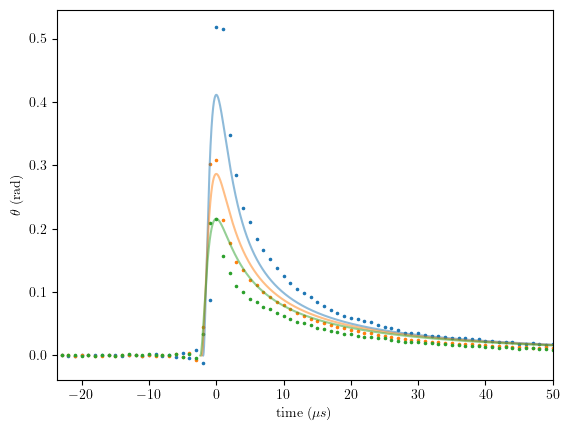

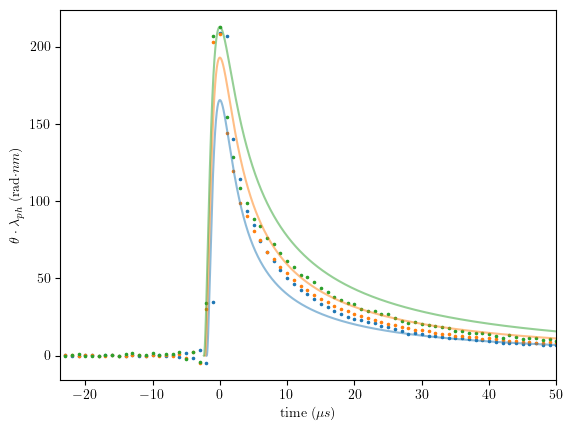

In [8]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5)
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.show()